# Quantum Game Theory - Sudoku

Sudoku is a numerical logic puzzle that involves filling a 9x9 grid divided into nine 3x3 subgrids or "boxes." Each row, column, and box must contain all the digits from 1 to 9 without repetition. The puzzle begins with some of the cells pre-filled with numbers, serving as clues. The objective is to complete the grid while adhering to the rule that each number can appear only once in each row, column, and box. The challenge and complexity of the puzzle vary based on the number and placement of the initial digits.

This is a new quantum algorithm designed specifically to tackle Sudoku puzzles. This development isn't just about gaming; it demonstrates the robust capabilities of the Dynex quantum computing platform. By harnessing the power of quantum mechanics, this algorithm not only speeds up solutions for recreational puzzles but also showcases potential applications in complex logistics, optimization problems, and beyond.

Coded By: Y3TI & Sam Rahmeh

In [1]:
import numpy as np
import pandas as pd
import dimod
import dynex
import matplotlib.pyplot as plt 
import timeit

In [4]:
def plot_mat(matrix, values=True):
    n = matrix.shape[0]
    fig, ax = plt.subplots()
    
    if values:
        ax.matshow(matrix[tuple([n-i for i in range(1, n+1)]),:], cmap=plt.cm.Blues)
        min_val, max_val = 0, n
        for i in range(n):
            for j in range(n):
                ax.text(i, j, str(matrix[n-j-1,i]), va='center', ha='center')
        ax.set_xlim(-0.5, n-0.5)
        ax.set_ylim(-0.5, n-0.5)
    else:
        ax.matshow(matrix, cmap=plt.cm.Blues)

        plt.show()

In [5]:
def CheckSudoku(grid):
    N = grid.shape[0]
    sq_N = int(np.sqrt(N))
    for i in range(N):
        if len(set(grid[i, :])) != N or len(set(grid[:, i])) != N:
            return False
    for i in range(0, N, sq_N):
        for j in range(0, N, sq_N):
            subgrid = grid[i:i+sq_N, j:j+sq_N]
            if len(set(subgrid.flatten())) != N:
                return False  
    return True

In [2]:
# Define sudoku size (must be a square number). 
N = 9
num_bits = N**3
sq_N = np.int64(np.sqrt(N))
z = np.array([i+1 for i in range(N)], dtype=np.int64)

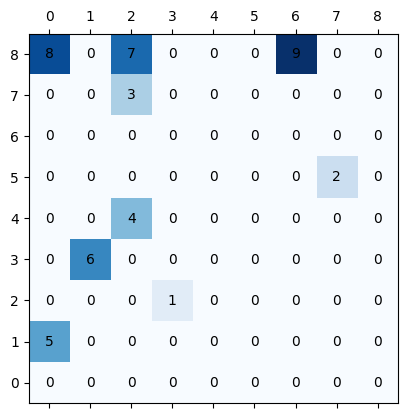

In [6]:
# Set initial values.
idx_init = np.random.choice(np.arange(N*N), N, replace=False)
a = np.array([[i for i in range(N)]+idx_init[j]*N for j in range(N)]).ravel()
x_init = {a[i] : int(i%N == i//N) for i in range(N*N)}

init_vec = np.zeros((num_bits, 1), dtype=np.int64)
idx = np.array([k for (k, v) in x_init.items() if v])
init_vec[idx] = 1

sudoku_init = (np.kron(np.identity(N**2, dtype=np.int64), z) @ init_vec).reshape((N, N))
plot_mat(sudoku_init)

## Quantum Sudoku Algorithm

In [7]:
# Initializing identity matrices and constructing constraints for rows and columns with high penalties
penaltyRC = 10000 
penaltySubGrid = 8000 
penalty_value = 10000 
idN = np.identity(N)
idSqN = np.identity(sq_N)
aRC = np.concatenate((np.kron(np.kron(idN, np.ones((1, N))), idN),  
                      np.kron(np.kron(np.ones((1, N)), idN), idN)))  
aSubGrid = np.kron(np.kron(np.kron(idSqN, np.ones((1, sq_N))), 
                           np.kron(idSqN, np.ones((1, sq_N)))), idN)
bRC = np.ones((2 * N * N, 1))
bSubGrid = np.ones((N * N, 1))
QRC = penaltyRC * (aRC.T @ aRC - 2 * np.diag(np.diag(aRC.T @ aRC)))
QSubGrid = penaltySubGrid * (aSubGrid.T @ aSubGrid - 2 * np.diag(np.diag(aSubGrid.T @ aSubGrid)))
qVal = np.zeros((num_bits, num_bits))
for i in range(num_bits):
    block_row = i // N 
    for j in range(block_row * N, (block_row + 1) * N): 
        if i != j:
            qVal[i, j] = penalty_value 
Q = QRC + QSubGrid + qVal

In [8]:
# Creating BQM from the QUBO matrices
bqm = dimod.BinaryQuadraticModel.empty(dimod.BINARY)
for i in range(num_bits):
    for j in range(i, num_bits):
        if i == j:
            bqm.add_variable(i, Q[i, i])
        else:
            bqm.add_interaction(i, j, Q[i, j])

bqm.offset += penaltyRC * (bRC.T @ bRC)[0, 0]
bqm.offset += penaltySubGrid * (bSubGrid.T @ bSubGrid)[0, 0]

for i, val in x_init.items():
    bqm.fix_variable(i, val)

In [15]:
# Compute on Dynex
model = dynex.BQM(bqm)
sampler = dynex.DynexSampler(model, mainnet=True, description='Quantum Sudoku Solution')
sampleset = sampler.sample(num_reads=10000, annealing_time=2000)

╭────────────┬──────────┬─────────────────┬─────────────┬───────────┬────────────────┬────────────┬─────────┬────────────────╮
│   DYNEXJOB │   QUBITS │   QUANTUM GATES │   BLOCK FEE │   ELAPSED │   WORKERS READ │   CIRCUITS │   STEPS │   GROUND STATE │
├────────────┼──────────┼─────────────────┼─────────────┼───────────┼────────────────┼────────────┼─────────┼────────────────┤
│       8192 │      656 │            8999 │        3.09 │      3.22 │              1 │      51040 │    2000 │    14316000.00 │
╰────────────┴──────────┴─────────────────┴─────────────┴───────────┴────────────────┴────────────┴─────────┴────────────────╯
╭────────────┬─────────────────┬────────────┬───────┬─────────────┬────────────────┬─────────────────────────────┬──────────────┬──────────╮
│     WORKER │         VERSION │   CIRCUITS │   LOC │      ENERGY │        RUNTIME │                 LAST UPDATE │        STEPS │   STATUS │
├────────────┼─────────────────┼────────────┼───────┼─────────────┼────────────────

In [16]:
print(sampleset)

   9 10 11 12 13 14 15 16 17 27 28 29 30 31 32 33 34 35 ... 728 energy num_oc.
0  0  0  0  0  1  0  0  0  0  0  1  0  0  0  0  0  0  0 ...   0    0.0       1
['BINARY', 1 rows, 1 samples, 648 variables]


In [17]:
solution = sampleset.first.sample

The solution is valid :)


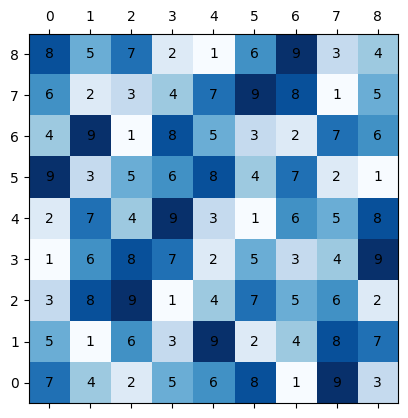

In [18]:
# Convert solution into sudoku grid
z = np.array([i+1 for i in range(N)], dtype=np.int64)
sol_vec = np.zeros((num_bits, 1), dtype=np.int64)
for i in range(num_bits):
    if i in x_init:
        sol_vec[i] = x_init[i]
    else:
        sol_vec[i] = solution[i]
sudoku_sol = (np.kron(np.identity(N**2, dtype=np.int64), z) @ sol_vec).reshape((N, N))
if CheckSudoku(sudoku_sol):
    print("The solution is valid :)")
    plot_mat(sudoku_sol)
else:
    print("The solution is not valid :(")